<a href="https://colab.research.google.com/github/DadaNanjesha/CASE_STUDY_MODEL_ENGINEERING/blob/main/CRISP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
# Importing required libraries
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [108]:
# Load the data
data = pd.read_excel("PSP_Jan_Feb_2019.xlsx")
# warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore")


In [109]:
# Drop unnecessary columns
data = data.drop('Unnamed: 0', axis=1)
# remove the data with missing values
data = data.dropna()

### Preliminary Data Exploration

In [110]:
print("\nData set:")
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")



Data set:
Number of Rows: 50410
Number of Columns: 7


In [111]:
# Display the first few rows of the dataset
print("\nData:")
data.head()


Data:


,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [112]:
# Check for Duplicate Rows
duplicates = data[data.duplicated()]
print(f"\nNumber of Duplicate Rows: {duplicates.shape[0]}")


Number of Duplicate Rows: 81


In [113]:
# remove the Duplicate data

print("\nData after removing the duplicates:")
print(f"Number of Rows befor removing the duplicates: {data.shape[0]}")
data = data.drop_duplicates()
print(f"Number of Rows after removing the duplicates: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")


Data after removing the duplicates:
Number of Rows befor removing the duplicates: 50410
Number of Rows after removing the duplicates: 50329
Number of Columns: 7


In [114]:
# Data Understanding
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50329 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50329 non-null  datetime64[ns]
 1   country     50329 non-null  object        
 2   amount      50329 non-null  int64         
 3   success     50329 non-null  int64         
 4   PSP         50329 non-null  object        
 5   3D_secured  50329 non-null  int64         
 6   card        50329 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


In [115]:
# Data Quality Measurements
data_quality = {
    'Null Values': data.isnull().sum(),
    'Unique Values': data.nunique(),
    'Summary Statistics': data.describe()
}

# Display Data Quality Measurements
for metric, value in data_quality.items():
    print(f"\n{metric}:\n{value}")



Null Values:
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

Unique Values:
tmsp          50121
country           3
amount          517
success           2
PSP               4
3D_secured        2
card              3
dtype: int64

Summary Statistics:
             amount       success    3D_secured
count  50329.000000  50329.000000  50329.000000
mean     202.379622      0.203223      0.238312
std       96.255629      0.402401      0.426055
min        6.000000      0.000000      0.000000
25%      133.000000      0.000000      0.000000
50%      201.000000      0.000000      0.000000
75%      269.000000      0.000000      0.000000
max      630.000000      1.000000      1.000000



PSP Success Rates:
             success
PSP                 
Goldcard    0.406172
Moneycard   0.218833
Simplecard  0.158212
UK_Card     0.194861
	

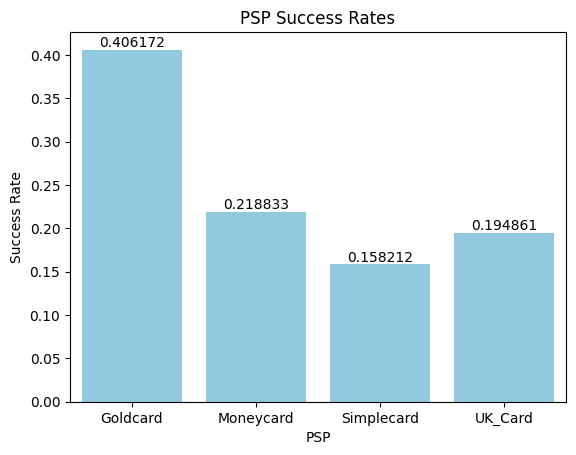

In [116]:
# List of PSPs and service fees
psp_fees = pd.DataFrame({
    'name': ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard'],
    'Fee_on_successful_transactions': [5, 10, 3, 1],
    'Fee_on_failed_transactions': [2, 5, 1, 0.5]
})
# Merge data with PSP fees
data = pd.merge(data, psp_fees, how='left', left_on='PSP', right_on='name')
# Calculate success rates for each category
psp_success_rates = data.groupby(['PSP'])[['success']].mean()
card_success_rates = data.groupby(['card'])[['success']].mean()
country_success_rates = data.groupby(['country'])[['success']].mean()

print("\nPSP Success Rates:")
print(psp_success_rates,end='\n\t')
# Plotting PSP Success Rates
ax = sns.barplot(x=psp_success_rates.index, y=psp_success_rates['success'], color='skyblue')
ax.bar_label(ax.containers[0])
plt.title("PSP Success Rates")
plt.ylabel("Success Rate")
plt.show()


Card Success Rates:
         success
card            
Diners  0.223247
Master  0.194252
Visa    0.208756
	

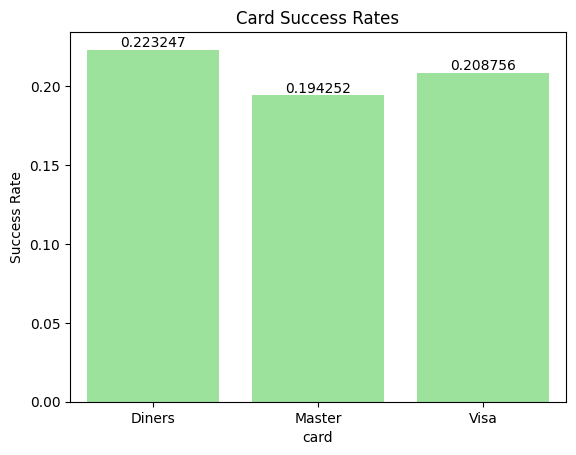

In [117]:
print("\nCard Success Rates:")
print(card_success_rates,end='\n\t')
# Plotting Card Success Rates
ax = sns.barplot(x=card_success_rates.index, y=card_success_rates['success'], color='lightgreen')
ax.bar_label(ax.containers[0])
plt.title("Card Success Rates")
plt.ylabel("Success Rate")
plt.show()


 Country Success Rates:
              success
country              
Austria      0.204969
Germany      0.201696
Switzerland  0.206025
	

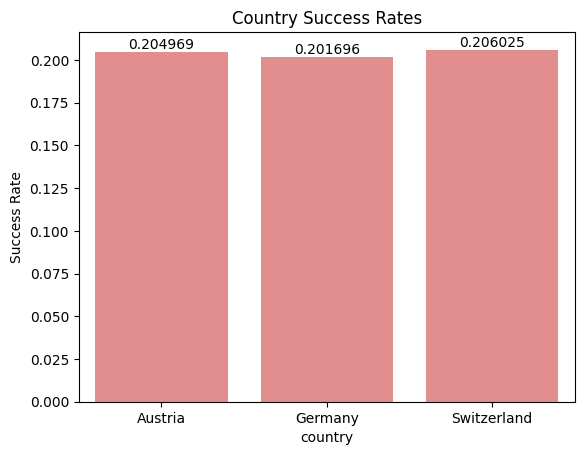

In [118]:
print("\n Country Success Rates:" )
print(country_success_rates,end='\n\t')

# Plotting Country Success Rates
ax = sns.barplot(x=country_success_rates.index, y=country_success_rates['success'], color='lightcoral')
ax.bar_label(ax.containers[0])
plt.title("Country Success Rates")
plt.ylabel("Success Rate")
plt.show()

Total number of Transactions : 50329
Transaction Status Failed: 40101
Transaction Status success: 10228


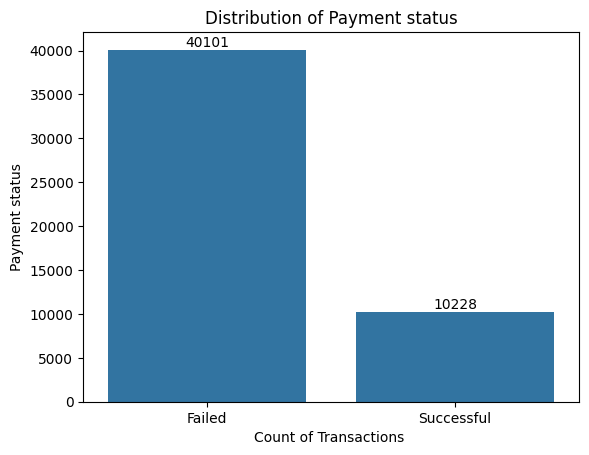

In [119]:
# Visualize success distribution
print(f"Total number of Transactions : {data['success'].count()}")
print(f"Transaction Status Failed: {data['success'].isin([0]).sum(axis=0)}")
print(f"Transaction Status success: {data['success'].isin([1]).sum(axis=0)}")
ax = sns.countplot(x='success', data=data)
ax.bar_label(ax.containers[0])
plt.title("Distribution of Payment status")
labels = ['Failed', 'Successful']
ax.set_xticklabels(labels)
plt.xlabel("Count of Transactions ")
plt.ylabel("Payment status")
plt.show()

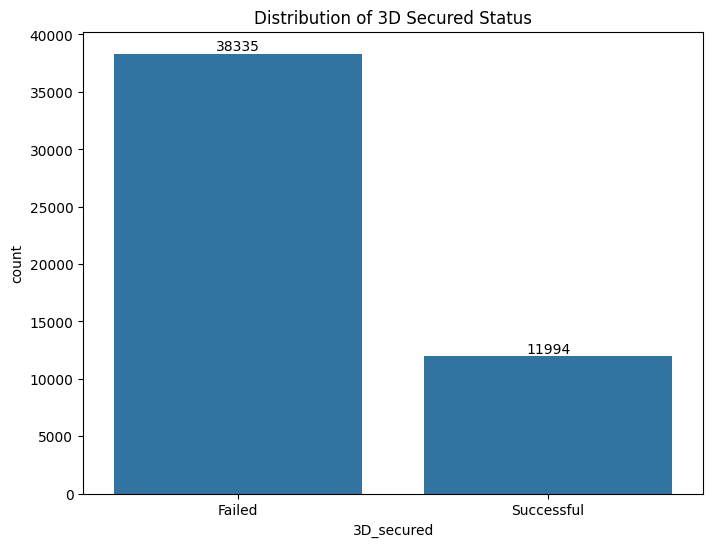

In [153]:
# Distribution of 3D Secured Status
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='3D_secured', data=data)
ax.bar_label(ax.containers[0])
plt.title("Distribution of 3D Secured Status")
labels = ['Failed', 'Successful']
ax.set_xticklabels(labels)
plt.show()

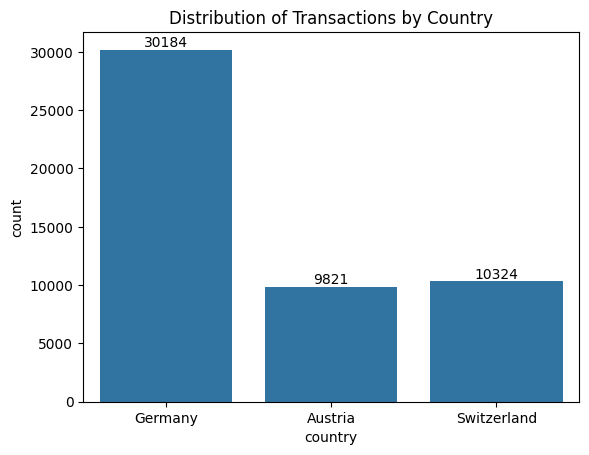

In [123]:
# Check the distribution of transactions by country
ax=sns.countplot(x='country', data=data)
ax.bar_label(ax.containers[0])
plt.title('Distribution of Transactions by Country')
plt.show()

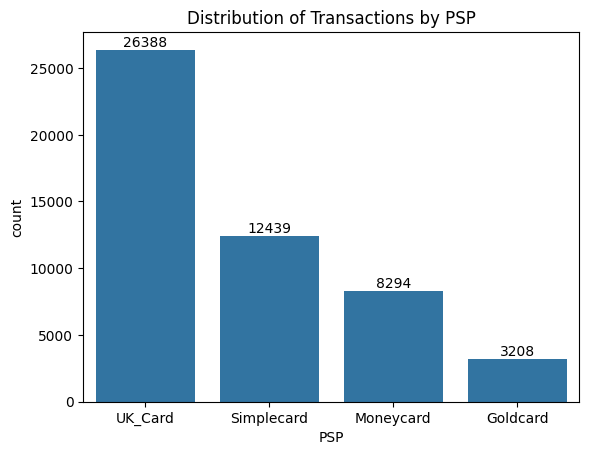

In [124]:
# Check the distribution of transactions by PSP
ax=sns.countplot(x='PSP', data=data)
ax.bar_label(ax.containers[0])
plt.title('Distribution of Transactions by PSP')
plt.show()

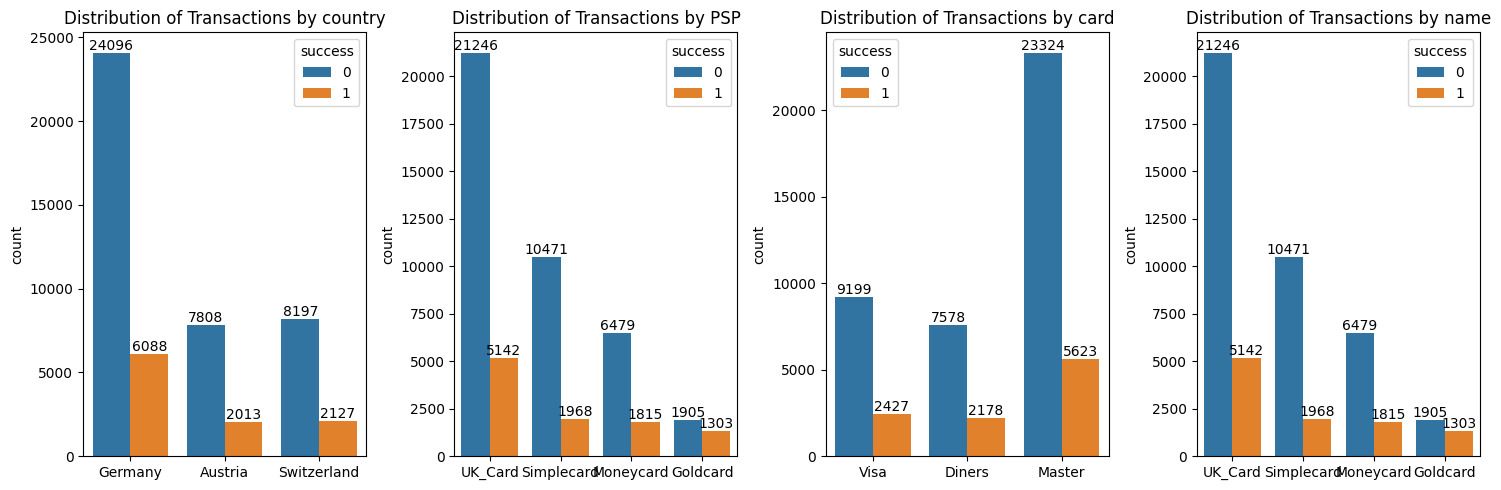

In [147]:
# Explore the distribution of categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns

# Set up subplots
num_columns = len(categorical_columns)
fig, axes = plt.subplots(1, num_columns, figsize=(15, 5))

# Iterate through each categorical column and plot on a separate axis
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue='success', data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of Transactions by {column}')
    axes[i].set_xlabel('')
    axes[i].bar_label(axes[i].containers[0])
    axes[i].bar_label(axes[i].containers[1])
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

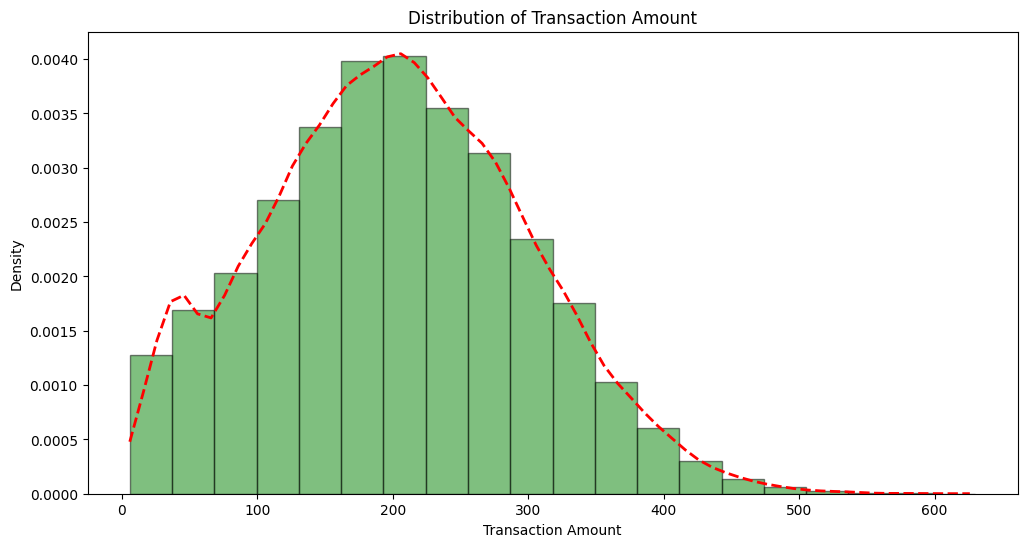

In [152]:
# Distribution of Amount
plt.figure(figsize=(12, 6))
plt.hist(data['amount'], bins=20, color='green',edgecolor='black', density=True, alpha=0.5)
kde = gaussian_kde(data['amount'])
x_vals = range(int(min(data['amount'])), int(max(data['amount'])), 10)
plt.plot(x_vals, kde(x_vals), color='red', linestyle='dashed', linewidth=2)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.show()

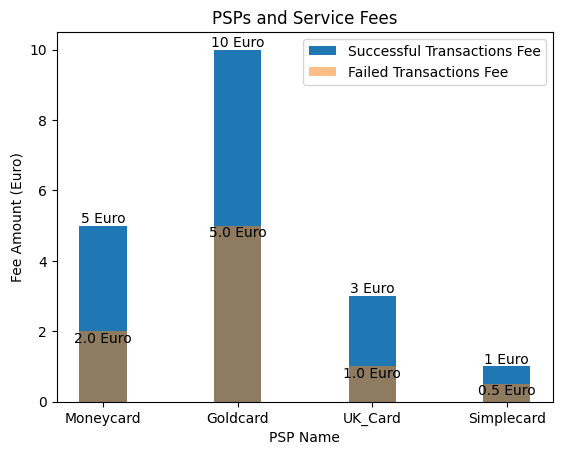

In [155]:
# List of PSPs and service fees
psp_fees = pd.DataFrame({
    'name': ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard'],
    'Fee_on_successful_transactions': [5, 10, 3, 1],
    'Fee_on_failed_transactions': [2, 5, 1, 0.5]
})
bar_width = 0.35
index = range(len(psp_fees['name']))
plt.bar(index, psp_fees['Fee_on_successful_transactions'], width=bar_width, label='Successful Transactions Fee')
plt.bar(index, psp_fees['Fee_on_failed_transactions'], width=bar_width, label='Failed Transactions Fee', alpha=0.5)
# Add values on top of the bars
for i, value in enumerate(psp_fees['Fee_on_successful_transactions']):
    plt.text(i, value, f"{value} Euro", ha='center', va='bottom')
for i, value in enumerate(psp_fees['Fee_on_failed_transactions']):
    plt.text(i, value, f"{value} Euro", ha='center', va='top')
plt.title("PSPs and Service Fees")
plt.xlabel("PSP Name")
plt.ylabel("Fee Amount (Euro)")
plt.xticks(index, psp_fees['name'])
plt.legend()
plt.show()

Transactions by PSP:
            Failed Transactions  Successful Transactions
PSP                                                     
Moneycard                  6479                     1815
Goldcard                   1905                     1303
UK_Card                   21246                     5142
Simplecard                10471                     1968


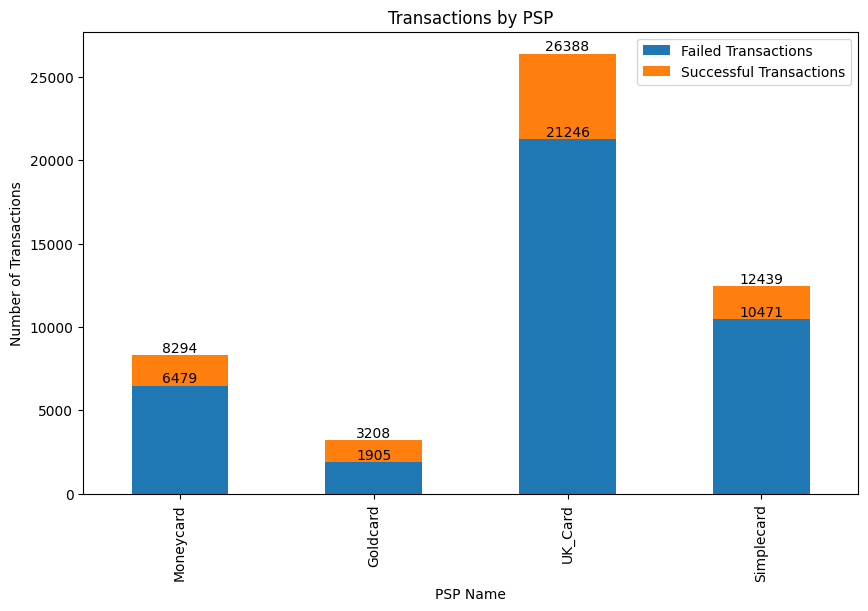

In [156]:
transactions_by_psp = data.groupby('PSP')['success'].value_counts().unstack(fill_value=0)
transactions_by_psp = transactions_by_psp.loc[psp_fees['name']]
transactions_by_psp.columns = ['Failed Transactions', 'Successful Transactions']
# Display the result
print("Transactions by PSP:")
print(transactions_by_psp)
ax = transactions_by_psp.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title("Transactions by PSP")
plt.xlabel("PSP Name")
plt.ylabel("Number of Transactions")
plt.show()

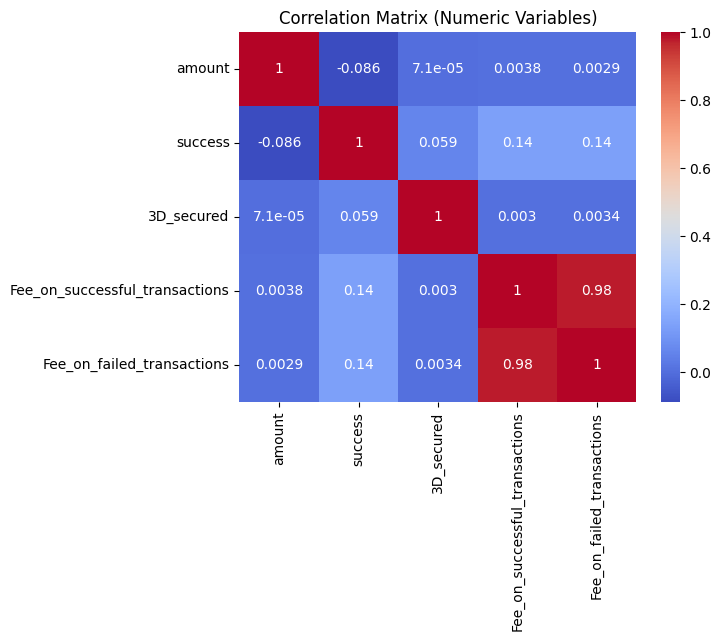

In [148]:
# Display correlation for numeric columns only
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Variables)')
plt.show()